## This is a demonstration of the generation of virtualzarr using an example documented 
here at https://virtualizarr.readthedocs.io/en/stable/index.html#features

In [114]:
import xarray as xr
from obstore.store import from_url
from virtualizarr import open_virtual_dataset, open_virtual_mfdataset
from virtualizarr.parsers import HDFParser
from virtualizarr.registry import ObjectStoreRegistry
import icechunk, kerchunk, parquet

In [101]:
#%pip install obstore

In [102]:
#%pip install virtualizarr icechunk

In [103]:
#%pip install --upgrade xarray

In [104]:
#%pip install icechunk

In [105]:
#%pip install kerchunk

In [106]:
#%pip install fastparquet

In [115]:
#Zarr can emit a lot of warnings about Numcodecs not being including in 
#the Zarr version 3 specification yet -- let's suppress those.

import warnings
warnings.filterwarnings(
  "ignore",
  message="Numcodecs codecs are not in the Zarr version 3 specification*",
  category=UserWarning
)

In [116]:
#We can use Obstore's obstore.store.from_url convenience method to create an 
#ObjectStore that can fetch data from the specified URLs.

bucket = "s3://nex-gddp-cmip6"
path = "NEX-GDDP-CMIP6/ACCESS-CM2/ssp126/r1i1p1f1/tasmax/tasmax_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2015_v2.0.nc"
url = f"{bucket}/{path}"
store = from_url(bucket, region="us-west-2", skip_signature=True)

#We also need to create an ObjectStoreRegistry 
#that maps the URL structure to the ObjectStore.

registry = ObjectStoreRegistry({bucket: store})


In [117]:
#Now, let's create a parser instance and create a virtual dataset by passing the URL, 
#parser, and registry to virtualizarr.open_virtual_dataset.

In [118]:
parser = HDFParser()
vds = open_virtual_dataset(
  url=f"{bucket}/{path}",
  parser=parser,
  registry=registry,
  loadable_variables=[],
)

In [119]:
print(vds)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
    time     (time) float64 3kB ManifestArray<shape=(365,), dtype=float64, ch...
    lat      (lat) float64 5kB ManifestArray<shape=(600,), dtype=float64, chu...
    lon      (lon) float64 12kB ManifestArray<shape=(1440,), dtype=float64, c...
Data variables:
    tasmax   (time, lat, lon) float32 1GB ManifestArray<shape=(365, 600, 1440...
Attributes: (12/22)
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    ...                    ...
    doi:                   https://doi.org/10.7917/OFSG3345
    external_variables:    areacella
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
    creation_date:         Sat Nov 16 13:31:18 PST 2024
    disclaimer:            These data are considered provisional

In [120]:
vds.tasmax

<xarray.DataArray 'tasmax' (time: 365, lat: 600, lon: 1440)> Size: 1GB
ManifestArray<shape=(365, 600, 1440), dtype=float32, chunks=(1, 600, 1440)>
Coordinates:
    time     (time) float64 3kB ManifestArray<shape=(365,), dtype=float64, ch...
    lat      (lat) float64 5kB ManifestArray<shape=(600,), dtype=float64, chu...
    lon      (lon) float64 12kB ManifestArray<shape=(1440,), dtype=float64, c...
Attributes:
    _FillValue:     AAAAgB2vFUQ=
    time:           60265.5
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          K
    coordinates:    height
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-11-08T10:48:26Z altered by CMOR: Treated scalar dime...
    missing_value:  1.0000000200408773e+20

In [121]:
#Since we specified loadable_variables=[], 
#no data has been loaded or copied in this process. 
#We have merely created an in-memory lookup table that points to the
#location of chunks in the original netCDF when data is needed later on. 
#The default behavior (loadable_variables=None) will load data associated with 
#coordinates but not data variables. The size represents the size of the original 
#dataset - you can see the size of the virtual dataset using the vz accessor:

In [122]:
print(f"Original dataset size: {vds.nbytes} bytes")
print(f"Virtual dataset size: {vds.vz.nbytes} bytes")

Original dataset size: 1261459240 bytes
Virtual dataset size: 11776 bytes


In [123]:
#VirtualiZarr's other top-level function is virtualizarr.open_virtual_mfdataset, which can open and virtualize multiple data sources into a single virtual dataset, similar to how xarray.open_mfdataset 
#opens multiple data files as a single dataset.

In [124]:
urls = [f"s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/ssp126/r1i1p1f1/tasmax/tasmax_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_{year}_v2.0.nc" for year in range(2015, 2017)]
vds = open_virtual_mfdataset(urls, parser = parser, registry = registry)
print(vds)

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 731, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2015-01-01T12:00:00 ... 2016-12-31T12:...
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    tasmax   (time, lat, lon) float32 3GB ManifestArray<shape=(731, 600, 1440...
Attributes: (12/22)
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    ...                    ...
    doi:                   https://doi.org/10.7917/OFSG3345
    external_variables:    areacella
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
    creation_date:         Sat Nov 16 13:31:18 PST 2024
    disclaimer:            These data are considered provisional an

In [125]:
vds = open_virtual_dataset(
    url=url,
    registry=registry,
    parser=parser,
    loadable_variables=['time']
)
print(vds)

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 2015-12-31T12:...
    lat      (lat) float64 5kB ManifestArray<shape=(600,), dtype=float64, chu...
    lon      (lon) float64 12kB ManifestArray<shape=(1440,), dtype=float64, c...
Data variables:
    tasmax   (time, lat, lon) float32 1GB ManifestArray<shape=(365, 600, 1440...
Attributes: (12/22)
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    ...                    ...
    doi:                   https://doi.org/10.7917/OFSG3345
    external_variables:    areacella
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
    creation_date:         Sat Nov 16 13:31:18 PST 2024
    disclaimer:            These data are considered provisional

In [126]:
#vds['tasmax'].data.manifest.dict()

In [127]:
#Loading CF-encoded time variables¶
#To decode time variables according to the 
#CF conventions upon loading, you must ensure that variable is 
#one of the loadable_variables and the decode_times argument of 
#open_virtual_dataset is set to True (decode_times defaults to None)
vds = open_virtual_dataset(
    url=url,
    registry=registry,
    parser=parser,
    loadable_variables=['time'],
    decode_times=True,
)
print(vds)


<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 2015-12-31T12:...
    lat      (lat) float64 5kB ManifestArray<shape=(600,), dtype=float64, chu...
    lon      (lon) float64 12kB ManifestArray<shape=(1440,), dtype=float64, c...
Data variables:
    tasmax   (time, lat, lon) float32 1GB ManifestArray<shape=(365, 600, 1440...
Attributes: (12/22)
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    ...                    ...
    doi:                   https://doi.org/10.7917/OFSG3345
    external_variables:    areacella
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
    creation_date:         Sat Nov 16 13:31:18 PST 2024
    disclaimer:            These data are considered provisional

In [128]:
#print(vds.tasmax.isel(time=0)) #does not work if we dont add tasmax to loadable and the manifest arrays do not support slicing indexing etc

Combining virtual datasets¶
In general we should be able to combine all the datasets from our archival files into one using some combination of calls to xarray.concat and xarray.merge. For combining along multiple dimensions in one call we also have xarray.combine_nested and xarray.combine_by_coords. If you're not familiar with any of these functions we recommend you skim through xarray's docs on combining.

In [129]:
url_1 = "s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/ssp126/r1i1p1f1/tasmax/tasmax_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2015_v2.0.nc"
url_2 = "s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/ssp126/r1i1p1f1/tasmax/tasmax_day_ACCESS-CM2_ssp126_r1i1p1f1_gn_2016_v2.0.nc"

In [ ]:
#If we can order the files beforehand, manually concatenate
'''

vds1 = open_virtual_dataset(url=url_1, registry=registry, parser=parser)
vds2 = open_virtual_dataset(url=url_2, registry=registry, parser=parser)
combined_vds = xr.concat([vds1, vds2], dim='time')
print(combined_vds)
'''

You can achieve both the opening and combining steps for multiple files in one go 
by using open_virtual_mfdataset.


In [ ]:
#We passed combine='nested' 
#to specify that we want the datasets to be combined in the order 
#they appear, using xr.combine_nested under the hood.

combined_vds = open_virtual_mfdataset(
    [url_1, url_2],
    registry=registry,
    parser=parser,
    combine="nested",
    concat_dim="time"
)

Ordering by coordinate values¶
If you're happy to load 1D dimension coordinates into memory, you can use their values to do the ordering for you!

In [ ]:
vds1 = open_virtual_dataset(url=url_1, registry=registry, parser=parser, 
                            loadable_variables=['time','lat', 'lon'], decode_times=True)
vds2 = open_virtual_dataset(url=url_2, registry=registry, parser=parser, 
                            loadable_variables=['time','lat', 'lon'], decode_times=True)
#Notice we don't have to specify the concatenation dimension 
#explicitly - xarray works out the correct ordering for us. 
#Even though we actually passed in the virtual datasets in the wrong order just now, they have been combined in the correct order such that the 1-dimensional time coordinate has ascending values. As a result our virtual dataset still has the data in the correct order.

#combined_vds = xr.combine_by_coords([vds2, vds1], combine_attrs="drop_conflicts")
#print(combined_vds)

In [ ]:
#Combine using coordinates in one go
combined_vds = open_virtual_mfdataset(
    [url_1, url_2],
    registry=registry,
    parser=parser,
    combine="by_coords",
    combine_attrs="drop_conflicts",
)

In [ ]:
combined_vds

In [ ]:
#The magic of VirtualiZarr is that you can 
#persist the virtual dataset to disk in a chunk references format such as Icechunk, 
#meaning that the work of constructing the single coherent dataset only needs to happen 
#once. For subsequent data access, you can use xarray.open_zarr to open that Icechunk 
#store, which on object storage is far faster than using xarray.open_mfdataset to 
#open the the original non-cloud-optimized files.

In [ ]:
#Let's persist the Virtual dataset using Icechunk. 
#First let's create an Icechunk configuration with permissions to access our data.

In [130]:
config = icechunk.RepositoryConfig.default()
container = icechunk.VirtualChunkContainer(
    url_prefix="s3://nex-gddp-cmip6/",
    store=icechunk.s3_store(region="us-west-2", anonymous=True),
)
config.set_virtual_chunk_container(container)

In [ ]:
#Now we can store the references to our data. 
#Here we store the references in an icechunk store 
#that only lives in memory, 
#but in most cases you'll store the "virtual" icechunk store in the cloud.

In [131]:
icechunk_store = icechunk.in_memory_storage()
repo = icechunk.Repository.create(icechunk_store, config)
session = repo.writable_session("main")
vds.vz.to_icechunk(session.store)
session.commit("Create virtual store")

'CRC8JD0TPTC4Y1MPTP9G'

In [133]:
storage = icechunk.local_filesystem_storage(
    path='test',
)

config = icechunk.RepositoryConfig.default()
config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3://nex-gddp-cmip6/", icechunk.s3_store(region="us-west-2")))
credentials = icechunk.containers_credentials({"s3://nex-gddp-cmip6/": icechunk.s3_credentials(anonymous=True)})
repo = icechunk.Repository.create(storage, config, credentials)

  2025-10-01T20:46:21.880707Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80



In [135]:
session = repo.writable_session("main")
vds.virtualize.to_icechunk(session.store)

In [137]:
session.commit("My first virtual store!")

'K6F9FF19GQT12E5Z4KSG'

In [138]:
ds = xr.open_zarr(
    session.store,
    zarr_version=3,
    consolidated=False,
    chunks={},
)

/vftmp/Aparna.Radhakrishnan/pid731721/ipykernel_3051517/2050398136.py:1: FutureWarning: zarr_version is deprecated, use zarr_format
  ds = xr.open_zarr(


In [139]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 2015-12-31T12:...
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    tasmax   (time, lat, lon) float32 1GB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes: (12/22)
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    ...                    ...
    doi:                   https://doi.org/10.7917/OFSG3345
    external_variables:    areacella
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
    creation_date:         Sat Nov 16 13:31:18 PST 2024
    disclaimer:            These data are considered provisional and subject ...
    tracking_id:           d4b2123b-abf9-4c3c-a780-58df6ce4e67f

In [140]:
ds.tasmax.isel(time=0) #yay!

<xarray.DataArray 'tasmax' (lat: 600, lon: 1440)> Size: 3MB
dask.array<getitem, shape=(600, 1440), dtype=float32, chunksize=(600, 1440), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 2015-01-01T12:00:00
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    time:           60265.5
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          K
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    cell_methods:   area: mean time: maximum
    cell_measures:  area: areacella
    history:        2019-11-08T10:48:26Z altered by CMOR: Treated scalar dime...

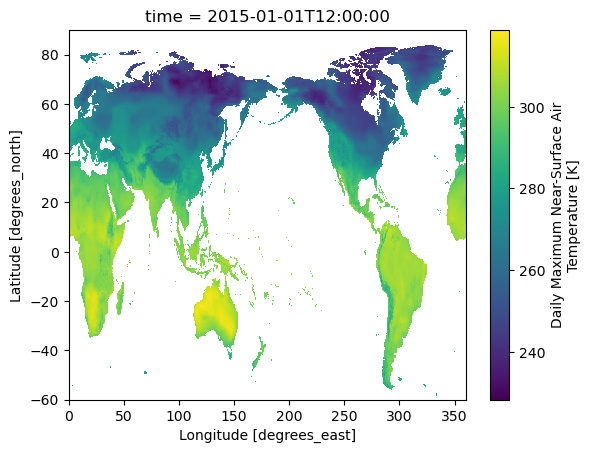

In [141]:
ds.tasmax.isel(time=0).plot()

In [148]:
# Using the saved icechunk store - persistency check 
import icechunk, xarray as xr

storage = icechunk.local_filesystem_storage(
    path='test')

config = icechunk.RepositoryConfig.default()
config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3://nex-gddp-cmip6/", icechunk.s3_store(region="us-west-2")))
credentials = icechunk.containers_credentials({"s3://nex-gddp-cmip6/": icechunk.s3_credentials(anonymous=True)})
repo = icechunk.Repository.open(storage, config, credentials)

session = repo.readonly_session(branch="main")
ds_test = xr.open_zarr(session.store, consolidated=False)
print(ds_test)


  2025-10-01T20:54:36.695380Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 365, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 2015-12-31T12:...
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
Data variables:
    tasmax   (time, lat, lon) float32 1GB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes: (12/22)
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    ...                    ...
    

In [142]:
#We can also use it with our analysis scripts by writing to kerchunk's format instead of icechunk

## Writing to Kerchunk's format and reading data via fsspec¶

The kerchunk library has its own specification for serializing virtual datasets as a JSON file or Parquet directory.

To write out all the references in the virtual dataset as a single kerchunk-compliant JSON or parquet file, you can use the virtualizarr.VirtualiZarrDatasetAccessor.to_kerchunk accessor method.

In [32]:
combined_vds.vz.to_kerchunk('combined.json', format='json')
#These zarr-like references can now be interpreted by fsspec, using kerchunk's 
#built-in xarray backend (kerchunk must be installed to use engine='kerchunk').

In [34]:
print(combined_vds)

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 731, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2015-01-01T12:00:00 ... 2016-12-31T12:...
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    tasmax   (time, lat, lon) float32 3GB ManifestArray<shape=(731, 600, 1440...
Attributes: (12/20)
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    ...                    ...
    title:                 ACCESS-CM2, r1i1p1f1, ssp126, global downscaled CM...
    resolution_id:         0.25 degree
    doi:                   https://doi.org/10.7917/OFSG3345
    external_variables:    areacella
    contact:               Dr. Bridget Thrasher: bridget@climateanalyticsgrou...
   

In [43]:
#you can also use parquet to scale better
combined_vds.vz.to_kerchunk('output/combined.parquet', format='parquet')

In [1]:
print(combined_vds)

NameError: name 'combined_vds' is not defined

In [75]:
from fsspec.implementations.reference import ReferenceFileSystem

def open_ref(ref_file, remote_protocol="s3", remote_options=None):
    for async_value in (False, True):
        try:
            fs = ReferenceFileSystem(
                ref_file,
                remote_protocol=remote_protocol,
                remote_options=remote_options or {},
                asynchronous=async_value
            )
            # if we can list keys, it works
            keys = list(fs.get_mapper("").keys())[:5]
            print(f" Works with asynchronous={async_value}, keys={keys}")
            return fs
        except Exception as e:
            print(f" Failed with asynchronous={async_value}: {e}")

fs = open_ref("combined.json", remote_protocol="s3", remote_options={"anon": True})
fs

 Works with asynchronous=False, keys=['.zattrs', '.zgroup', 'lat/.zarray', 'lat/.zattrs', 'lat/0']


In [79]:
import xarray as xr
from fsspec.implementations.reference import ReferenceFileSystem

# Options for accessing the *remote* NetCDF in S3
so = {"anon": True}   # or False if you need AWS creds

# Build reference filesystem
fs = ReferenceFileSystem(
    "combined.json",           # local kerchunk JSON
    remote_protocol="s3",    # where the original NetCDF actually lives
    remote_options=so,
    asynchronous=False       # must be explicit to avoid mismatch
)


'\n# Create mapper & open with xarray\nmapper = fs.get_mapper("")\nds = xr.open_dataset(mapper, engine="zarr", chunks={})\nprint(ds)\n'

In [88]:
import xarray as xr
from fsspec.implementations.reference import ReferenceFileSystem

# Explicitly set async mode OFF everywhere
so = {"anon": True, "asynchronous": True}

fs = ReferenceFileSystem(
    "combined.json",             # local kerchunk JSON
    remote_protocol="s3",      # remote data is in S3
    remote_options=so,
    asynchronous=True         # must match remote_options
)

mapper = fs.get_mapper("")
ds = xr.open_zarr(mapper, consolidated=False, chunks={})
print(ds)


<xarray.Dataset> Size: 3GB
Dimensions:  (time: 731, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2015-01-01T12:00:00 ... 2016-12-31T12:...
  * lat      (lat) float64 5kB -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    tasmax   (time, lat, lon) float32 3GB dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes: (12/20)
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    activity:              NEX-GDDP-CMIP6
    Conventions:           CF-1.7
    frequency:             day
    ...                    ...
    title:                 ACCESS-CM2, r1i1p1f1, ssp126, global downscaled CM...
    resolution_id:         0.25 degree
    doi:                   https://doi.org/10.7917/OFSG3345
    external_variables:    areacella
    contact:               Dr. Bridget Thrasher: bridget@climateanaly

In [ ]:
ts = ds.tasmax.sel(lat=0, lon=180, method="nearest")
ts.plot()
plt.show()


In [ ]:
#todo zmetadata consolidated, edit metadata in reference file